# Project Description

The goal is to develop a machine learning model for the used car sales service capable of accurately predicting car market values. The model will be trained using a comprehensive dataset containing technical specifications, feature details, and prices of similar cars.

Key success criteria for this project include:

- Prediction Quality: The model must deliver high accuracy in price predictions, minimizing error to build user trust in the application.
- Training Time: Efficient model training is critical for iteration and fine-tuning, allowing the service to update the model periodically with new data as the market changes.
- Prediction Time: Fast prediction time is essential for an optimal user experience, enabling real-time market value assessments.

This project aims to combine high prediction accuracy with optimal efficiency, offering a seamless, user-friendly experience for anyone seeking to evaluate the value of their car.

## 00 Notebook setup

Imports

In [1]:
pip install phik -q


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Standard libraries
import pandas as pd
import numpy as np

# Data viz
import matplotlib.pyplot as plt
import seaborn as sns

# Additional lib
from phik import phik_matrix

# Linear
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import root_mean_squared_error

# Tree and Ensemble
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Gradient Boosting
from lightgbm import LGBMRegressor

# Pipeline tools
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    LabelEncoder
)
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score

# Transformers
from sklearn.base import BaseEstimator, TransformerMixin

Functions

In [3]:
# Function that plots a histogram and a box plot

def plot_hist_box(df, col_name: str):

    f, (ax_box, ax_hist) = plt.subplots(
        2,
        sharex=True,
        gridspec_kw={"height_ratios": (.15, .85)},
        figsize=(8, 6)
    )

    sns.set(style="whitegrid")

    sns.boxplot(df[col_name], orient="h", ax=ax_box)

    sns.histplot(df[col_name], ax=ax_hist, kde=True)

    ax_box.set(xlabel='')

    plt.suptitle(f'Distribution of {col_name}', fontsize=14)

    plt.show()

In [4]:
# Function that finds and drops duplicates

def find_and_drop_total_dups(df):
    if df.duplicated().sum() > 0:
        print(f'Number of total duplicates: {df.duplicated().sum()}')
        df = df.drop_duplicates()
        print('Duplicates removed from DataSet')
    else:
        print('No total duplicates found in the DataSet')


In [5]:
# Function that displays statistical info

def show_stats(df, column_name: str):
    print(f'Statics for {column_name}')
    display(df[[column_name]].describe().T)

Constants

In [6]:
RANDOM_STATE = 42

Reading Data

In [7]:
dates = ['DateCrawled', 'DateCreated', 'LastSeen']
df = pd.read_csv(
    '/Users/autos.csv',
    parse_dates=dates
)

## 1 Data Overview

In [8]:
# Separate 20% of the data to use for testing later
df, test = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)

In [9]:
# Overview
df.head(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
107156,2016-03-17 15:47:14,16780,suv,2009,manual,140,tiguan,90000,3,gasoline,volkswagen,yes,2016-03-17,0,41069,2016-04-06 23:45:20
20206,2016-03-14 19:36:43,9100,coupe,1987,manual,160,other,150000,9,petrol,porsche,no,2016-03-14,0,23826,2016-04-06 04:17:19
287570,2016-03-10 00:57:05,9999,coupe,1968,manual,94,other,30000,6,petrol,porsche,no,2016-03-10,0,87746,2016-03-10 07:49:36


In [10]:
# Data types check
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 283495 entries, 107156 to 121958
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        283495 non-null  datetime64[ns]
 1   Price              283495 non-null  int64         
 2   VehicleType        253498 non-null  object        
 3   RegistrationYear   283495 non-null  int64         
 4   Gearbox            267544 non-null  object        
 5   Power              283495 non-null  int64         
 6   Model              267684 non-null  object        
 7   Kilometer          283495 non-null  int64         
 8   RegistrationMonth  283495 non-null  int64         
 9   FuelType           257066 non-null  object        
 10  Brand              283495 non-null  object        
 11  Repaired           226394 non-null  object        
 12  DateCreated        283495 non-null  datetime64[ns]
 13  NumberOfPictures   283495 non-null  int64   

In [11]:
# Check for duplicates
find_and_drop_total_dups(df)

Number of total duplicates: 2
Duplicates removed from DataSet


In [12]:
# Check for missing values
df.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105811
RegistrationYear     0.000000
Gearbox              0.056266
Power                0.000000
Model                0.055772
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.093226
Brand                0.000000
Repaired             0.201418
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

- The DataSet contains 15 features (both numeric & categorical) and a target feature (continuous numeric value).

- All data types are correct.

- Some features have missing values. This will be handled further on.

## 2 EDA

### 2.1 Target

In [13]:
target = 'Price'

In [14]:
show_stats(df, target)

Statics for Price


,count,mean,std,min,25%,50%,75%,max
Price,283495.0,4406.829461,4505.093187,0.0,1050.0,2700.0,6399.0,20000.0


- The mean is significantly higher than the median and standard deviation is very hight indicating a right-skewed distribution.

- The minimum value is 0, which suggests that some instances may have incorrect entries.

- The maximum price is 20,000.0, which is a significant outlier compared to the majority of the data.

In [15]:
(df[target] == 0).mean()

0.03028624843471666

- 3% of the target feature has values equal to 0, which will does not provide valuable information for the model.

- This data will be removed, it can help to ensure that your model isn't biased or misled by these values.

In [16]:
df = df[df[target] > 0]

In [17]:
show_stats(df, target)

Statics for Price


,count,mean,std,min,25%,50%,75%,max
Price,274909.0,4544.464234,4506.026177,1.0,1200.0,2850.0,6500.0,20000.0


- There is still a number of relatively low values, i.e. 1 eur.

In [18]:
q_1 = df[df[target] <= 1200]

In [19]:
show_stats(q_1, target)

Statics for Price


,count,mean,std,min,25%,50%,75%,max
Price,71454.0,676.991015,320.404227,1.0,450.0,699.0,950.0,1200.0


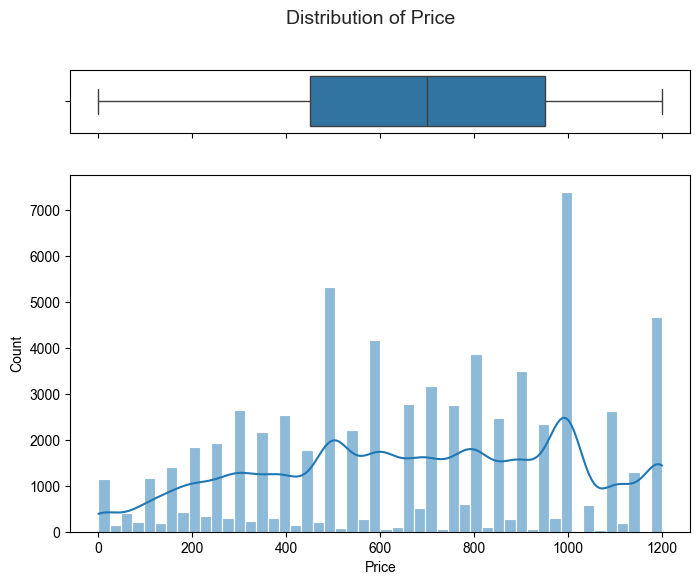

In [20]:
plot_hist_box(q_1, target)

- Technically, the owner is entitled to set any price for their vehicle. However the value of, for instance, 1 eur looks like a mistake in data.

- I will, however, check whether the cars which cost less than 1000 eur are retro cars.

In [21]:
_df = df[df[target] <= 1000]
_df['RegistrationYear'].value_counts()

RegistrationYear
1999    7492
2000    7191
1998    6798
1997    6742
1996    5122
        ... 
1400       1
4800       1
5300       1
9450       1
2222       1
Name: count, Length: 97, dtype: int64

- The years vary, which indicates that the price of less that 1000 eur is definitely a mistake.

- Such data can affect the linear model's prediction ability which is why it will be removed from the dataset.

In [22]:
(df[target] <= 100).mean()

0.010367066920326363

In [23]:
df = df[df[target] > 1000]

In [24]:
show_stats(df, target)

Statics for Price


,count,mean,std,min,25%,50%,75%,max
Price,212914.0,5691.708093,4511.897306,1001.0,2200.0,4000.0,7950.0,20000.0


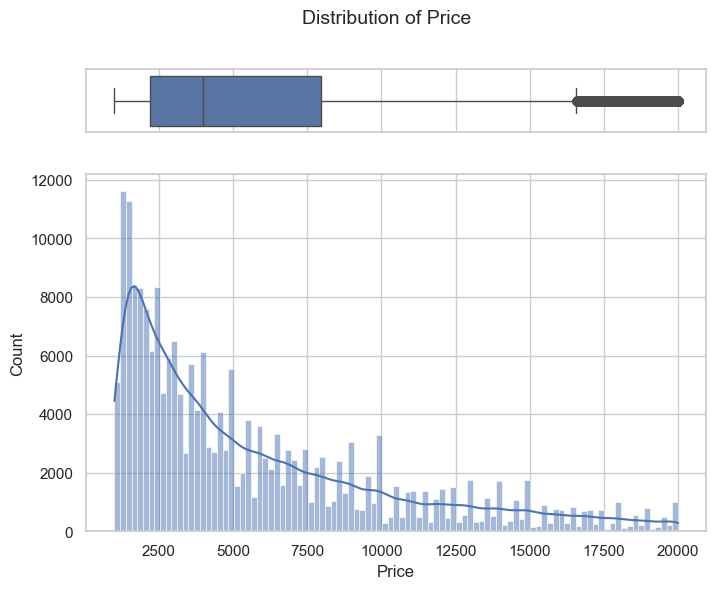

In [25]:
plot_hist_box(df, target)

- Given the skewed distribution of the target variable, I will apply a log transformation.

- This can help make the distribution more normal and improve model performance, especially for regression models.

In [26]:
df['Price_log'] = np.log10(df['Price'])
target_log = 'Price_log'

In [27]:
show_stats(df, target_log)

Statics for Price_log


,count,mean,std,min,25%,50%,75%,max
Price_log,212914.0,3.623958,0.341767,3.000434,3.342423,3.60206,3.900367,4.30103


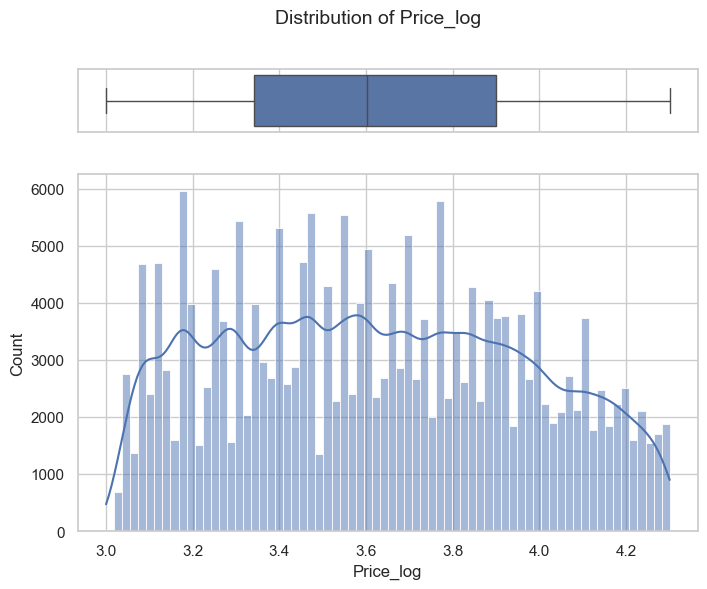

In [28]:
plot_hist_box(df, target_log)

### 2.2 Registration Year & Columns with Dates

In [29]:
show_stats(df, 'RegistrationYear')

Statics for RegistrationYear


,count,mean,std,min,25%,50%,75%,max
RegistrationYear,212914.0,2004.85543,61.013807,1000.0,2001.0,2005.0,2008.0,9999.0


- It looks like there are errors in RegistrationYear.

In [30]:
for date in dates:
    show_stats(df, date)

Statics for DateCrawled


,count,mean,min,25%,50%,75%,max
DateCrawled,212914,2016-03-21 14:21:43.013061120,2016-03-05 14:06:23,2016-03-13 13:38:14,2016-03-21 18:55:29,2016-03-29 14:58:40.750000128,2016-04-07 14:36:58


Statics for DateCreated


,count,mean,min,25%,50%,75%,max
DateCreated,212914,2016-03-20 20:13:49.315122432,2014-03-10 00:00:00,2016-03-13 00:00:00,2016-03-21 00:00:00,2016-03-29 00:00:00,2016-04-07 00:00:00


Statics for LastSeen


,count,mean,min,25%,50%,75%,max
LastSeen,212914,2016-03-30 11:46:58.090468352,2016-03-05 14:15:39,2016-03-24 03:16:30,2016-04-04 18:43:05,2016-04-06 11:46:22,2016-04-07 14:58:50


- The dates for crawling, creation, and last seen are all within a narrow, consistent timeframe, mostly from early March to early April 2016.

- Using the DateCrawled, DateCreated, and LastSeen features could of course help with initial analysis and model development, especially for understanding time-based market dynamics.

- However, for the app that calculates car value based on user inputs, the final deployed model should be trained to predict prices based solely on physical car characteristics, making it fully applicable to user-driven predictions without time-related information.

- These features will not be used during the modelling process.

In [31]:
df[df['RegistrationYear'] > 2016]['RegistrationYear'].unique()

array([2017, 2018, 5000, 9999, 7000, 4500, 5911, 4000, 6000, 2019, 7100,
       8888, 7800, 3200, 3000, 2900, 2800, 9000, 4100, 8500])

- Listings were created from 2014 to 2016 which is why registration year cannot be later that 2016.

- Also, there are apparently wrong years which have to be removed form the DataSet.

In [32]:
df = df[df['RegistrationYear'] <= 2016]

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, согласно дате выгрузки базы, у нас не может быть год регистрации больше 2016 года 
</div>

In [33]:
show_stats(df, 'RegistrationYear')

Statics for RegistrationYear


,count,mean,std,min,25%,50%,75%,max
RegistrationYear,204634.0,2003.644873,9.65503,1000.0,2001.0,2004.0,2008.0,2016.0


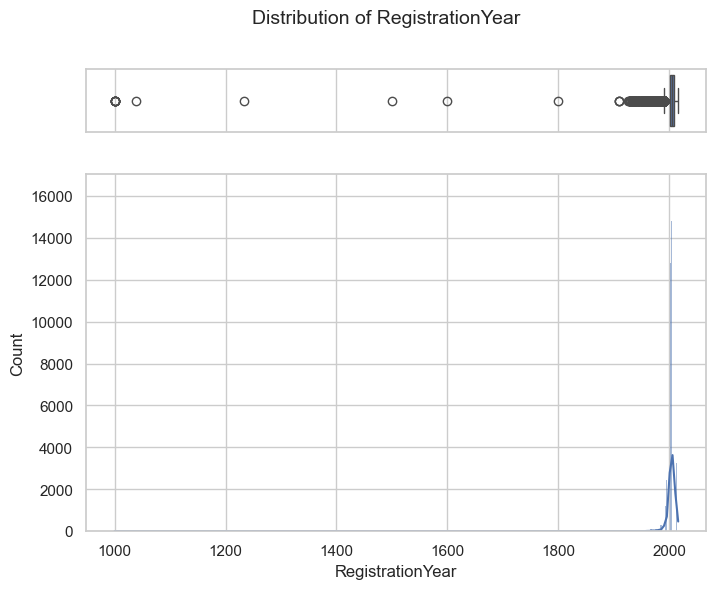

In [34]:
plot_hist_box(df, 'RegistrationYear')

In [35]:
df[df['RegistrationYear'] < 1900]['RegistrationYear'].unique()

array([1000, 1039, 1001, 1500, 1234, 1800, 1600])

In [36]:
df = df[df['RegistrationYear'] >= 1900]

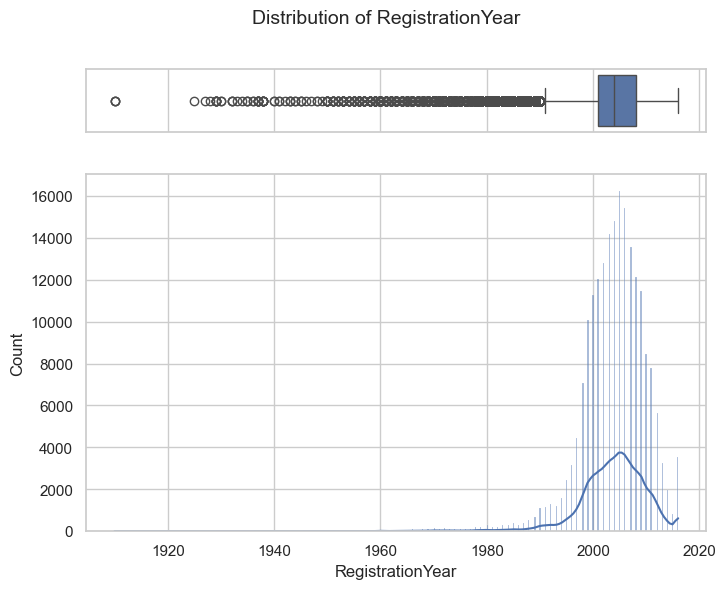

In [37]:
plot_hist_box(df, 'RegistrationYear')

### 2.3 Vehicle Type & Model

In [38]:
df['VehicleType'].unique()

array(['suv', 'coupe', 'convertible', 'sedan', 'wagon', 'bus', 'small',
       'other', nan], dtype=object)

In [39]:
df['VehicleType'].value_counts(normalize=True, dropna=False)

VehicleType
sedan          0.285621
wagon          0.203870
small          0.195825
bus            0.101045
convertible    0.072495
coupe          0.051529
suv            0.044575
NaN            0.035998
other          0.009041
Name: proportion, dtype: float64

In [40]:
df.groupby('VehicleType')[['Price']].mean()

,Price
VehicleType,
bus,6056.605146
convertible,7341.765808
coupe,7174.891218
other,5003.706486
sedan,5759.142769
small,3937.676192
suv,9481.438548
wagon,5913.680746


In [41]:
cat_cols = df.select_dtypes(include='object').columns.to_list()
_df = df[cat_cols].dropna()
matrix = phik_matrix(_df).sort_values(by='VehicleType')
matrix

,VehicleType,Gearbox,Model,FuelType,Brand,Repaired
Repaired,0.060563,0.016758,0.091864,0.030872,0.037597,1.000000
Gearbox,0.282672,1.000000,0.655252,0.136472,0.497207,0.016758
FuelType,0.332328,0.136472,0.557200,1.000000,0.319598,0.030872
Brand,0.620010,0.497207,0.998327,0.319598,1.000000,0.037597
Model,0.927859,0.655252,1.000000,0.557200,0.998327,0.091864
VehicleType,1.000000,0.282672,0.927859,0.332328,0.620010,0.060563


- VehicleType is correlated with Model.

- I will fill the missing values for VehicleType with the most common according to Model.

In [42]:
df['Model'] = df['Model'].fillna('other')
most_common_vehicle_type = df.groupby('Model')['VehicleType'].agg(lambda x: x.mode().iloc[0]).reset_index()
most_common_vehicle_type.columns = ['Model', 'MostCommonVehicleType']

In [43]:
most_common_vehicle_type.head(10)

,Model,MostCommonVehicleType
0,100,sedan
1,145,sedan
2,147,sedan
3,156,wagon
4,159,wagon
5,1_reihe,small
6,1er,sedan
7,200,sedan
8,2_reihe,small
9,300c,wagon


In [44]:
df = df.merge(most_common_vehicle_type, how='left', on='Model')
df['VehicleType'] = df['VehicleType'].fillna(df['MostCommonVehicleType'])

In [45]:
df['Model'].nunique()

249

- There's a large number of unique values.

- I will combine the rare ones together.

In [46]:
model_counts = df['Model'].value_counts(normalize=True)
model_counts

Model
other                 0.107032
golf                  0.080529
3er                   0.062437
a4                    0.032225
passat                0.031292
                        ...   
charade               0.000015
samara                0.000015
rangerover            0.000010
elefantino            0.000005
range_rover_evoque    0.000005
Name: proportion, Length: 249, dtype: float64

In [47]:
rare_models = model_counts[model_counts < 0.01].index
rare_models

Index(['zafira', '3_reihe', 'vectra', 'clio', 'mondeo', 'twingo', 'octavia',
       'fabia', 'ibiza', 'cooper',
       ...
       'kappa', 'move', 'i3', 'kalina', 'serie_3', 'charade', 'samara',
       'rangerover', 'elefantino', 'range_rover_evoque'],
      dtype='object', name='Model', length=228)

In [48]:
df['Model_new'] = df['Model'].apply(lambda x: 'other' if x in rare_models else x)

In [49]:
df['Model_new'].nunique()

21

### 2.3 Gearbox

In [50]:
df['Gearbox'].value_counts(normalize=True, dropna=False)

Gearbox
manual    0.742700
auto      0.223242
NaN       0.034058
Name: proportion, dtype: float64

In [51]:
df['Gearbox'] = df['Gearbox'].fillna('unknown')

In [52]:
df.groupby('Gearbox')[['Price']].mean()

,Price
Gearbox,
auto,7706.122045
manual,5238.018878
unknown,4177.227866


- The average Price values for each Gearbox category suggest that vehicles with "auto" gearboxes are generally more expensive than those with "manual" gearboxes, and that the "unknown" category is associated with the lowest average price. Given this, it could be beneficial to retain "unknown" as a separate category, as it may carry unique information about lower-priced vehicles.

### 2.4 Fuel Type

In [53]:
df['FuelType'].unique()

array(['gasoline', 'petrol', nan, 'lpg', 'electric', 'hybrid', 'cng',
       'other'], dtype=object)

In [54]:
df['FuelType'] = df['FuelType'].replace({'petrol':'gasoline'}).fillna('other')

In [55]:
df.groupby('FuelType')[['Price']].mean()

,Price
FuelType,
cng,5051.646438
electric,7883.716667
gasoline,5847.345003
hybrid,10471.385057
lpg,4713.051149
other,4291.462630


In [56]:
df['FuelType'].value_counts(normalize=True, dropna=False)

FuelType
gasoline    0.929714
other       0.050283
lpg         0.017007
cng         0.001852
hybrid      0.000850
electric    0.000293
Name: proportion, dtype: float64

- Given the distribution of values in FuelType, it makes sense to simplify it by creating a binary feature for the linear model, particularly if the majority of vehicles use gasoline.

In [57]:
df['FuelTypeIsGas'] = df['FuelType'].apply(lambda x: 1 if x == 'gasoline' else 0)

In [58]:
df['FuelTypeIsGas'].value_counts(normalize=True)

FuelTypeIsGas
1    0.929714
0    0.070286
Name: proportion, dtype: float64

### 2.5 Power

In [59]:
show_stats(df, 'Power')

Statics for Power


,count,mean,std,min,25%,50%,75%,max
Power,204621.0,122.78815,184.456538,0.0,80.0,116.0,150.0,20000.0


- It looks like there are some extreme values, specifically the maximum value of 20,000 hp, which is unusually high for most vehicles and likely an error.

- Most vehicles have power outputs in the range of 50 to 1,500 hp.

In [60]:
(df['Power'] < 50).mean()

0.07868205120686537

In [61]:
(df['Power'] > 1500).mean()

0.0005033696443669028

- Since the proportions are quite low, I will filter out the unrealistic values.

In [62]:
df = df[(df['Power'] >= 50) & (df['Power'] <= 1500)]

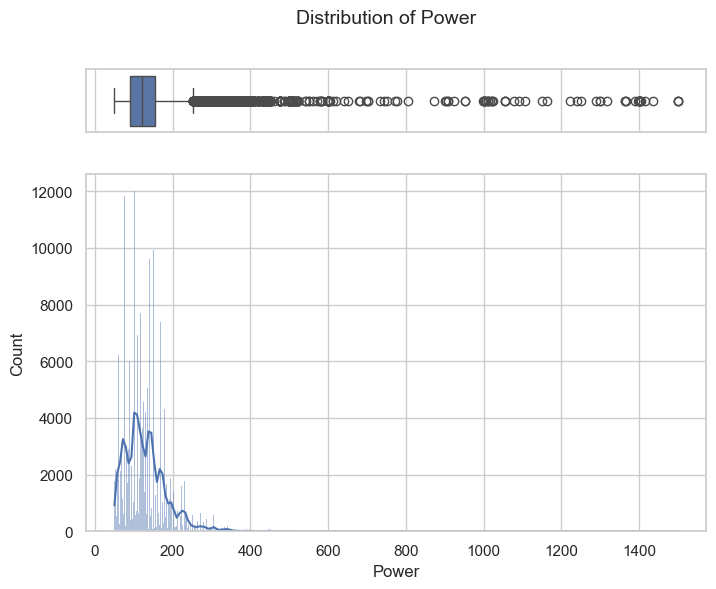

In [63]:
plot_hist_box(df, 'Power')

- This will also have to be log-transformed for the linear model.

In [64]:
df['Power_log'] = np.log10(df['Power'])

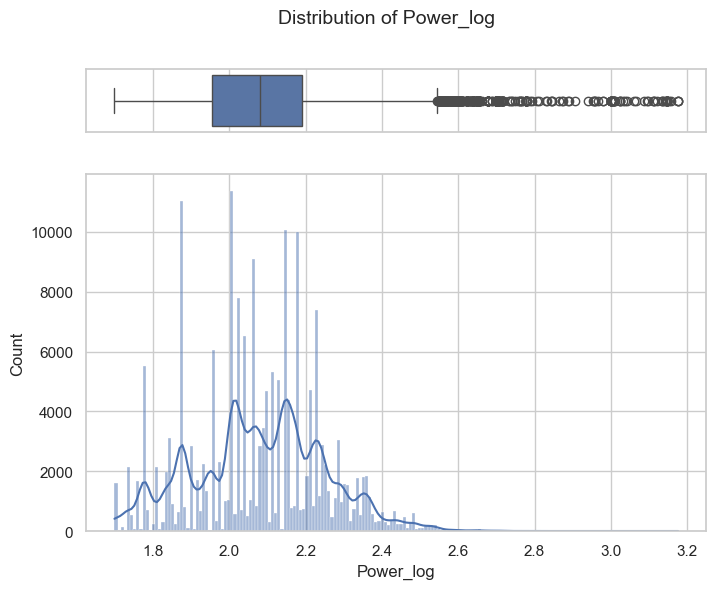

In [65]:
plot_hist_box(df, 'Power_log')

### 2.6 Repaired

In [66]:
df['Repaired']  = df['Repaired'].fillna('unknown')

In [67]:
df['Repaired'].unique()

array(['yes', 'no', 'unknown'], dtype=object)

In [68]:
df['Repaired'].value_counts(normalize=True)

Repaired
no         0.822268
unknown    0.117436
yes        0.060297
Name: proportion, dtype: float64

In [69]:
df.groupby('Repaired')['Price'].mean()

Repaired
no         6260.772917
unknown    4514.535364
yes        3785.989262
Name: Price, dtype: float64

-  The 'unknown' might hold significance (e.g., reflecting cars with uncertain repair histories), so I will create binary features to provide the linear model with additional context.

In [70]:
df['IsRepaired'] = df['Repaired'].apply(lambda x: 1 if x == 'yes' else 0)
df['IsUnknownRepairedStatus'] = df['Repaired'].apply(lambda x: 1 if x == 'unknown' else 0)

### 2.7 Postal Code

In [71]:
df['PostalCode'].nunique()

7980

- This feature is not a continuous value which has too many unique values.

- Besides, this information is about the user not the vehicle.

- This feature doesn't appear to be informative which is why this column will be dropped.

### 2.8 Kilometer

In [72]:
show_stats(df, 'Kilometer')

Statics for Kilometer


,count,mean,std,min,25%,50%,75%,max
Kilometer,188418.0,125602.569818,37929.665537,5000.0,100000.0,150000.0,150000.0,150000.0


- It looks like Kilometer column has a maximum value of 150,000 km for many entries, as shown by the 50th (median), 75th percentiles, and maximum values all being 150,000 km.

- This dataset is from listings or used car data, so 150,000 km might be a frequently chosen maximum value, either as a placeholder or an approximation.

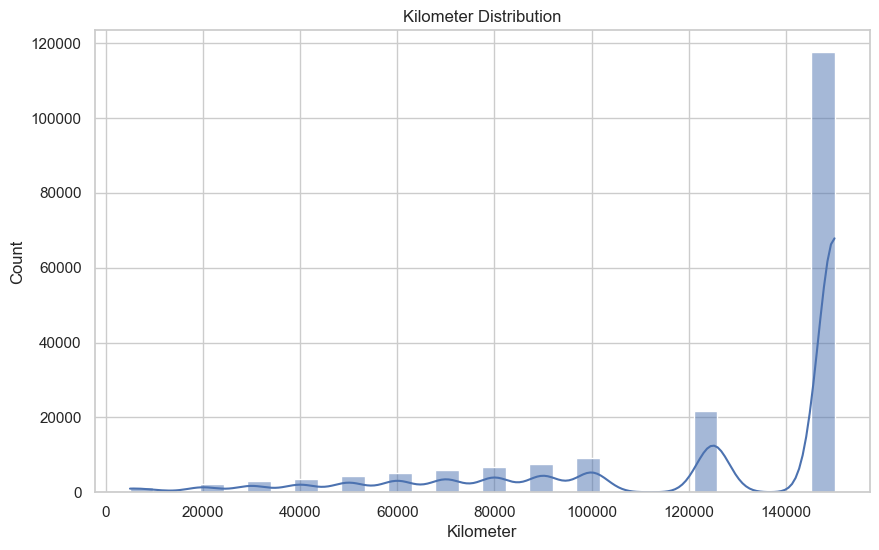

In [73]:
# Histogram for Kilometer
plt.figure(figsize=(10, 6))
sns.histplot(df['Kilometer'], bins=30, kde=True)
plt.title('Kilometer Distribution')
plt.xlabel('Kilometer')
plt.show()

In [74]:
(df['Kilometer'] == 150000).mean()

0.6238522858750225

- 65% of dataset has a value of 150,000 km, it's very likely that this value represents a cap or default for high-mileage vehicles, rather than an accurate measure of their mileage.

- I will binarize this feature.

In [75]:
df['IsHighMileage'] = df['Kilometer'].apply(lambda x: 1 if x >= 140000 else 0)

In [76]:
df['IsHighMileage'].value_counts(normalize=True)

IsHighMileage
1    0.623852
0    0.376148
Name: proportion, dtype: float64

### 2.9 Registration Month

In [77]:
df['RegistrationMonth'].unique()

array([ 3,  9,  6,  8,  7, 10,  4, 11,  0,  2, 12,  1,  5])

In [78]:
df.groupby('RegistrationMonth')[['Price']].mean()

,Price
RegistrationMonth,
0,3927.763178
1,6067.451363
2,5899.449348
3,5892.173172
4,6089.821461
5,5915.226632
6,5971.583838
7,6060.670434
8,5885.174115


- Given the distribution, this does not appear to be an informative feature.

### 2.10 Number of Pictures

In [79]:
show_stats(df, 'NumberOfPictures')

Statics for NumberOfPictures


,count,mean,std,min,25%,50%,75%,max
NumberOfPictures,188418.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- This is likely a mistake and this feature is not informative thus will be dropped.

## 3 Correlation

In [80]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen',
       'Price_log', 'MostCommonVehicleType', 'Model_new', 'FuelTypeIsGas',
       'Power_log', 'IsRepaired', 'IsUnknownRepairedStatus', 'IsHighMileage'],
      dtype='object')

In [81]:
remove_cols = [
    'RegistrationMonth', 
    'NumberOfPictures', 
    'MostCommonVehicleType',
    'PostalCode'
]

In [82]:
df_cleared = df.drop(columns=dates+remove_cols, axis=1)

<Axes: title={'center': 'Features Correlation'}>

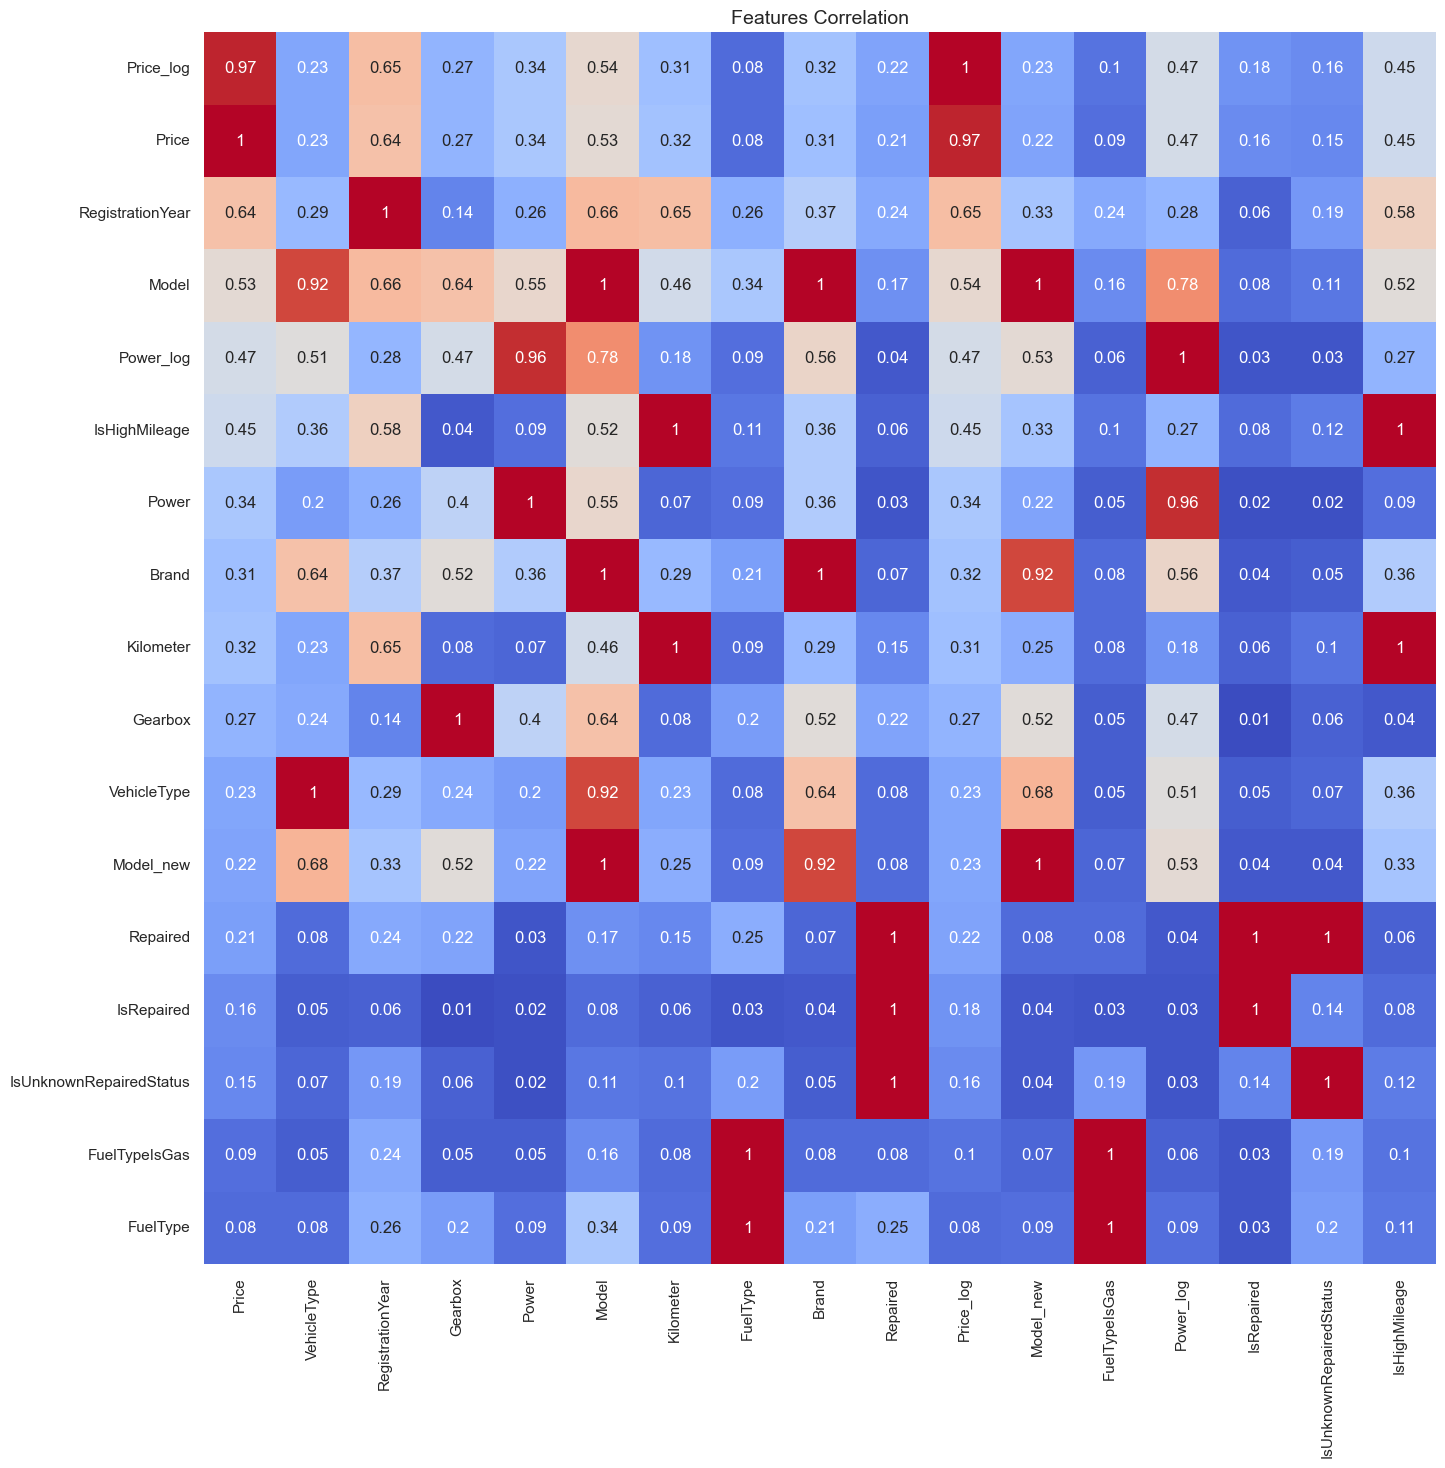

In [112]:
INTERVAL_COLS = [
    'Price', 
    #'VehicleType', 
    #'RegistrationYear', 
    #'Gearbox', 
    'Power', 
    #'Model',
    #'Kilometer', 
    #'FuelType', 
    #'Brand', 
    #'Repaired', 
    'Price_log', 
    #'Model_new',
    #'FuelTypeIsGas', 
    'Power_log', 
    #'IsRepaired', 
    #'IsUnknownRepairedStatus',
    #'IsHighMileage'
]

matrix = df_cleared.phik_matrix(interval_cols=INTERVAL_COLS).sort_values(by='Price_log', ascending=False)
plt.figure(figsize=(16, 16))
plt.title('Features Correlation',
          fontsize=14)
sns.heatmap(matrix.round(2),
            annot = True, square=True,
            cmap='coolwarm',
            cbar=False)

## 4 Linear Regression

In [84]:
# ======== Select the columns ========
COLS_TO_KEEP = [
    #'Price', 
    'VehicleType', 
    'RegistrationYear', 
    'Gearbox', 
    'Power', 
    'Model',
    #'Kilometer',
    #'FuelType',
    #'Brand',
    #'Repaired',
    'Price_log',
    'Model_new',
    'FuelTypeIsGas', 
    'Power_log', 
    'IsRepaired', 
    'IsUnknownRepairedStatus',
    'IsHighMileage'
]

# ======= Filter DataFrame =======
df_lr = df[COLS_TO_KEEP]

# ======== Define the variables ========
TARGET = 'Price_log'

FEATURES = df_lr.drop(TARGET, axis=1)

NUMERICAL = FEATURES.select_dtypes(exclude='object').columns.to_list()
CAT_FEATURES = FEATURES.select_dtypes(include='object').columns.to_list()

In [85]:
# ======== Split the dataset ========
X_train = FEATURES
y_train = df_lr[TARGET]

# ======== Categorical and numerical transformers ========
transformer_num = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

transformer_ord = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# ======== Preprocessor for categorical + numeric values ========
preprocessor = ColumnTransformer(transformers=[
    ('numeric', transformer_num, NUMERICAL),
    ('encoder', transformer_ord, CAT_FEATURES)
])

# ======== Pipeline with model ========
price_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=0.001, random_state=RANDOM_STATE))
])

# ======== Parameters for Randomized Search ========
param_grid = [
    {
        'regressor': [Lasso(alpha=0.001, random_state=RANDOM_STATE)],
        'preprocessor__numeric': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'regressor': [Ridge(alpha=0.001, random_state=RANDOM_STATE)],
        'preprocessor__numeric': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    {
        'regressor': [ElasticNet(alpha=0.001, random_state=RANDOM_STATE)],
        'preprocessor__numeric': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [86]:
%%time
# ======== Search for optimal params  ========
search = RandomizedSearchCV(
    estimator = price_pipe,
    param_distributions = param_grid,
    n_iter=6,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    cv=5,
    random_state=RANDOM_STATE
)

CPU times: user 25 µs, sys: 10 µs, total: 35 µs
Wall time: 42 µs


In [87]:
%%time
# ======== Fit the search to the training data ========
search.fit(X_train, y_train)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning:

CPU times: user 2.02 s, sys: 335 ms, total: 2.35 s
Wall time: 25.4 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['RegistrationYear',
                                                                                'Power',
                                                                                'FuelTypeIsGas',
                                                                                'Power_log',
                                                                                'IsRepaired',
                                                                                'IsUnknownRepairedStatus',
                                                                                'IsHighMileage']),
                                                                              ('encoder',
                                                                               Pipeline(steps=[('encoder',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ign...
                                         'regressor': [Lasso(alpha=0.001,
                                                             random_state=42)]},
                                        {'preprocessor__numeric': [StandardScaler(),
                                                                   MinMaxScaler(),
                                                                   'passthrough'],
                                         'regressor': [Ridge(alpha=0.001,
                                                             random_state=42)]},
                                        {'preprocessor__numeric': [StandardScaler(),
                                                                   MinMaxScaler(),
                                                                   'passthrough'],
                                         'regressor': [ElasticNet(alpha=0.001,
                                                                  random_state=42)]}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [88]:
# ======== Output the best parameters and the corresponding RMSE ========
print("Best parameters:", search.best_params_)
print("Best RMSE (log-transformed):", -search.best_score_)

Best parameters: {'regressor': Ridge(alpha=0.001, random_state=42), 'preprocessor__numeric': 'passthrough'}
Best RMSE (log-transformed): 0.2025755434690495


In [89]:
# ======== Calculate RMSE on original scale ========
y_pred_log = search.predict(X_train)

y_pred_original = 10 ** y_pred_log - 1
y_train_original = 10 ** y_train - 1

rmse_original = root_mean_squared_error(y_true=y_train_original, y_pred=y_pred_original)
print("Best RMSE (original):", rmse_original)

Best RMSE (original): 2774.5467141713893


In [90]:
# Output the params 
res = pd.DataFrame(search.cv_results_).sort_values(by='mean_test_score', ascending=False).head(1)
res_linear = res[['mean_fit_time', 'mean_score_time', 'mean_test_score']].copy()
res_linear['mean_test_score'] = rmse_original
res_linear

,mean_fit_time,mean_score_time,mean_test_score
2,0.849079,0.166556,2774.546714


- Even though the Linear Regression is rather a fast model, on average, the model’s predictions are about 2774 euros off from the actual car prices.

- And its approximately 300 euros higher than the required metric's value (of 2500).

## 5 Tree

In [91]:
# ======== Select the columns ========
COLS_TO_KEEP = [
    'Price', 
    'VehicleType', 
    'RegistrationYear', 
    'Gearbox', 
    'Power', 
    'Model',
    'Kilometer',
    'FuelType',
    'Brand',
    'Repaired',
    #'Price_log',
    #'Model_new',
    #'FuelTypeIsGas', 
    #'Power_log', 
    #'IsRepaired', 
    #'IsUnknownRepairedStatus',
    #'IsHighMileage'
]

# ======= Filter DataFrame =======
df_tree = df[COLS_TO_KEEP]

# ======== Define the variables ========
TARGET = 'Price'

FEATURES = df_tree.drop(TARGET, axis=1)

NUMERICAL = FEATURES.select_dtypes(exclude='object').columns.to_list()
CAT_FEATURES = FEATURES.select_dtypes(include='object').columns.to_list()

In [92]:
# ======== Split the dataset ========
X_train = FEATURES
y_train = df_tree[TARGET]

# ======== Categorical transformer ========
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan), CAT_FEATURES)
    ],
    remainder='passthrough'
)

# ======== Pipeline with preprocessing and model ========
price_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('estimator', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

# ======== Params for Search ========
param_grid = [
    {
        'estimator': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'estimator__max_depth': range(3, 15),
        'estimator__min_samples_split': range(2, 10),
        'estimator__min_samples_leaf': range(1, 10)
    }
]

In [93]:
%%time
# ======== Search for optimal params  ========
search_tree = RandomizedSearchCV(
    estimator = price_pipe,
    param_distributions = param_grid,
    n_iter=10,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    cv=5,
    random_state=RANDOM_STATE
)

CPU times: user 24 µs, sys: 1e+03 ns, total: 25 µs
Wall time: 31 µs


In [94]:
%%time
# ======== Fit the search to the training data ========
search_tree.fit(X_train, y_train)

CPU times: user 4.29 s, sys: 214 ms, total: 4.5 s
Wall time: 11.6 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                              unknown_value=nan),
                                                                               ['VehicleType',
                                                                                'Gearbox',
                                                                                'Model',
                                                                                'FuelType',
                                                                                'Brand',
                                                                                'Repaired'])])),
                                             ('estimator',
                                              DecisionTreeRegressor(random_state=42))]),
                   n_jobs=-1,
                   param_distributions=[{'estimator': [DecisionTreeRegressor(random_state=42)],
                                         'estimator__max_depth': range(3, 15),
                                         'estimator__min_samples_leaf': range(1, 10),
                                         'estimator__min_samples_split': range(2, 10)}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [95]:
# ======== Output the best parameters and the corresponding RMSE ========
print("Best parameters:", search_tree.best_params_)
print("Best RMSE:", -search_tree.best_score_)

Best parameters: {'estimator__min_samples_split': 2, 'estimator__min_samples_leaf': 1, 'estimator__max_depth': 13, 'estimator': DecisionTreeRegressor(random_state=42)}
Best RMSE: 1965.43176442527


In [96]:
res = pd.DataFrame(search_tree.cv_results_).sort_values(by='mean_test_score', ascending=False).head(1)
res_tree = res[['mean_fit_time', 'mean_score_time', 'mean_test_score']].copy()
res_tree['mean_test_score'] = abs(res_tree['mean_test_score'])
res_tree

,mean_fit_time,mean_score_time,mean_test_score
1,0.931756,0.114045,1965.431764


- The Tree model takes longer, but the metric has dropped to 1961 euros.

## 6 LightGBM

In [97]:
# ======= Define Columns to Keep =======
COLS_TO_KEEP = [
    'Price', 
    'VehicleType', 
    'RegistrationYear', 
    'Gearbox', 
    'Power', 
    'Model',
    'Kilometer',
    'FuelType',
    'Brand',
    'Repaired',
    #'Price_log',
    #'Model_new',
    #'FuelTypeIsGas', 
    #'Power_log', 
    #'IsRepaired', 
    #'IsUnknownRepairedStatus',
    #'IsHighMileage'
]

# ======= Filter DataFrame =======
df_gb = df[COLS_TO_KEEP].copy()

# ======= Define Target and Features =======
TARGET = 'Price'
FEATURES = df_gb.drop(TARGET, axis=1)
CAT_FEATURES = FEATURES.select_dtypes(include='object').columns.to_list()

# ======= Convert to Categorical Type =======
for cat in CAT_FEATURES:
    df_gb[cat] = df_gb[cat].astype('category')



In [98]:
# ======= Split into Train and Test Sets =======
X_train = df_gb.drop('Price', axis=1)
y_train = df_gb['Price']

In [99]:
# ======= Define Model =======
estimator = LGBMRegressor(random_state=RANDOM_STATE)

# ======= Hyperparameter Tuning =======
param_grid = {
    'n_estimators': [100, 200, 300],  
    'learning_rate': [0.01, 0.05, 0.1], 
    'max_depth': [-1, 5, 10, 15],  
    'num_leaves': [31, 50, 100],  
    'min_child_samples': [10, 20, 30],  
    'subsample': [0.7, 0.8, 0.9, 1.0],  
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

In [100]:
%%time
# ======= Search for Optimal Parameters =======
search_gb = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=param_grid,
    n_iter=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    cv=5,
    random_state=RANDOM_STATE
)

# ======= Fit the Model =======
search_gb.fit(X_train, y_train)

# ======= Output Results =======
print("Best parameters:", search_gb.best_params_)
print("Best RMSE:", -search_gb.best_score_)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 632
[LightGBM] [Info] Number of data points in the train set: 150734, number of used features: 9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Number of data points in the train set: 150734, number of used features: 9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead

In [101]:
res = pd.DataFrame(search_gb.cv_results_).sort_values(by='mean_test_score', ascending=False).head(1)
res_gb = res[['mean_fit_time', 'mean_score_time', 'mean_test_score']].copy()
res_gb['mean_test_score'] = abs(res_gb['mean_test_score'])
res_gb

,mean_fit_time,mean_score_time,mean_test_score
2,30.181887,0.511792,1610.309426


## 7. Evaluation

In [102]:
# Compare the performance of each of the models
compare = pd.concat([res_linear, res_tree, res_gb])
compare.index = ['Linear', 'Tree', 'LGBM']
compare

,mean_fit_time,mean_score_time,mean_test_score
Linear,0.849079,0.166556,2774.546714
Tree,0.931756,0.114045,1965.431764
LGBM,30.181887,0.511792,1610.309426


- Given that the ideal metric should not exceed 2500 euros, we need to focus on the mean_test_score, ensuring it aligns with this cost limit.


    - **Linear Model:** the score exceeds the 2500-euro limit, making it less ideal despite its efficient training and scoring times.
    - **Tree Model:** the score is below the 2500-euro threshold, making it a feasible option in terms of cost. Additionally, it has relatively fast training and scoring times, providing a balance between cost and efficiency.
    - **LGBM Model:** this score is also below 2500 euros, making it suitable from a cost perspective. However, it has significantly longer training and scoring times, which may impact usability, especially if real-time prediction is needed.

- Recommendation

    - The Tree model is not the best choice. Even though it is balancing the desired cost metric and efficiency, it is prone to overfitting. It's more advisable to use trees in ensembles. However, that will significantly slow down the fit time.
    - The LGBM model also meets the cost criteria. Its performance accuracy should outweigh speed.

# 8. Predictions

In [103]:
# Check the test set
test.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105723
RegistrationYear     0.000000
Gearbox              0.054773
Power                0.000000
Model                0.054943
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.091232
Brand                0.000000
Repaired             0.198281
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

In [104]:
# ======== Select the columns ========

COLS_TO_KEEP = [
    'Price', 
    'VehicleType', 
    'RegistrationYear', 
    'Gearbox', 
    'Power', 
    'Model',
    'Kilometer',
    'FuelType',
    'Brand',
    'Repaired'
]

In [105]:
# Custom transformers for the test set preprocessing

class FeatureDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_keep: list[str]):
        self.columns_to_keep = columns_to_keep
    
    def fit(self, X: pd.DataFrame, y=None):
        return self

    def transform(self, X: pd.DataFrame):
        return X[self.columns_to_keep]


class FillMissing(BaseEstimator, TransformerMixin):
    def fit(self, X: pd.DataFrame, y=None):
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()
        X['Repaired'] = X['Repaired'].fillna('unknown')
        X['Model'] = X['Model'].fillna('other')
        X['Gearbox'] = X['Gearbox'].fillna('unknown')
        return X


class MyFuelTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X: pd.DataFrame, y=None):
        return self
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()
        X['FuelType'] = X['FuelType'].replace({'petrol': 'gasoline'}).apply(
            lambda x: 'gasoline' if x == 'gasoline' else 'other'
        )
        return X


class MyVehicleTypeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X: pd.DataFrame, y=None):
        return self
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()
        # Compute the most common VehicleType for each Model
        most_common_vehicle_type = (
            X.groupby('Model')['VehicleType']
            .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
            .reset_index()
            .rename(columns={'VehicleType': 'MostCommonVehicleType'})
        )

        # Merge the most common VehicleType back into the original DataFrame
        X = X.merge(most_common_vehicle_type, how='left', on='Model')
        X['VehicleType'] = X['VehicleType'].fillna(X['MostCommonVehicleType'])
        X.drop(columns=['MostCommonVehicleType'], inplace=True)  # Clean up auxiliary column
        return X

In [106]:
# Pipeline for test set preprocessing

test_transformer = Pipeline(steps=[
    ('dropper', FeatureDropper(columns_to_keep=COLS_TO_KEEP)),
    ('missing', FillMissing()),
    ('fuel', MyFuelTransformer()),
    ('vehicle', MyVehicleTypeTransformer())
])

In [107]:
# Preprocess the test set

test = test_transformer.fit_transform(test)

In [108]:
# ======= Features =======
TARGET = 'Price'

CAT_FEATURES = (
    test.drop(TARGET, axis=1)
    .select_dtypes(include='object')
    .columns
    .to_list()
)

# ======= Convert to Categorical Type =======
for cat in CAT_FEATURES:
    test[cat] = test[cat].astype('category')

In [109]:
# ======= Split into Train and Test Sets =======
X_test = test.drop('Price', axis=1)
y_test = test['Price']

In [110]:
# Predictions on the test set
predictions = search_gb.predict(X_test)

In [111]:
rmse_test = root_mean_squared_error(y_pred=predictions, y_true=y_test)
rmse_test 

1850.6737921949496

- The RMSE on the test set perfectly meets the Client criteria.

**Conclusion**

- This project successfully evaluated multiple machine learning models — linear regression, decision tree, and LightGBM - to find the most suitable model for predicting car market values in a used car sales application. 

- Among these, the LightGBM model emerged as the best performer, achieving a low RMSE of 1624, which indicates its superior accuracy in estimating car prices.

- This result meets the project's primary success criteria of high prediction quality, ensuring users can trust the model's price assessments. 

- Additionally, LightGBM's efficient training and fast prediction capabilities allow for regular model updates as market data evolves, maintaining relevance and responsiveness for users seeking accurate, real-time valuations. 